# Teaching task event files
Natalia Vélez, March 2022

In [1]:
import os,sys,warnings
import pandas as pd
import numpy as np
from os.path import join as opj

sys.path.append('..')
from utils import str_extract, int_extract, gsearch, read_json, write_json

sys.path.append('../2_behavioral')
import teaching_models as teach

Loading teaching problems
{'A': [[0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0]],
 'B': [[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'C': [[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'D': [[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]]}
Participants excluded from analysis:
[3, 17]
Cleaning up human behavioral data
    subject  run  block_idx  ex_idx first_movement   start  problem  \
0         1    1          0       0         [0, 1]  [0, 0]       22   
1         1    1          0       1         [0, 1]  [0, 0]       22   
3         1    1          1   

Load valid participants:

In [2]:
valid_participants = np.loadtxt('../1_preprocessing/outputs/valid_participants.txt')
valid_participants = ['sub-%02d' % s for s in valid_participants]
print(valid_participants)

['sub-01', 'sub-02', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30']


### Vanilla event files (for top-level folder)

Find behavioral files:

In [3]:
data_dir = '../../'
original_files = gsearch(data_dir, 'behavioral', '*.json')
original_files = [f for f in original_files if 'run-practice' not in f] # trim out practice runs
original_files.sort()

print(f'Found {len(original_files)} behavioral files')
print(*original_files[:10], sep='\n')

Found 299 behavioral files
../../behavioral/sub-01_task-teaching_run-01_behavioral_1628798255.json
../../behavioral/sub-01_task-teaching_run-02_behavioral_1628798680.json
../../behavioral/sub-01_task-teaching_run-03_behavioral_1628799162.json
../../behavioral/sub-01_task-teaching_run-04_behavioral_1628800012.json
../../behavioral/sub-01_task-teaching_run-05_behavioral_1628800423.json
../../behavioral/sub-01_task-teaching_run-06_behavioral_1628800796.json
../../behavioral/sub-01_task-teaching_run-07_behavioral_1628801177.json
../../behavioral/sub-01_task-teaching_run-08_behavioral_1628801584.json
../../behavioral/sub-01_task-teaching_run-09_behavioral_1628802076.json
../../behavioral/sub-01_task-teaching_run-10_behavioral_1628802432.json


Helper function: Transforms raw data into BIDS-compliant events files

In [4]:
def data_wrangling(f):

    # load input data
    in_df = pd.read_json(f)

    # copy input data
    out_df = (
        in_df
        .copy()
        .rename(columns={
            'ons': 'onset',
            'dur': 'duration',
            'type': 'trial_type',
            'problem_idx': 'block_no',
            'ex_idx': 'trial_no',
            'problem': 'stimuli',
            'order': 'stimuli_order',
            'rt': 'response_time'
        })
    )

    # create additional rows for motor response
    choose_trials = out_df[~pd.isna(out_df.movements)]
    rate_trials = out_df[out_df.trial_type == 'rate']

    # add cursor movements from choose trials
    movement_list = []
    for _, row in choose_trials.iterrows():
        movements = row.movements
        movement_dict = [{'trial_type': 'motor', 'onset': row.onset + m[1], 'duration': 0} for m in movements if m[1] >= 0]
        movement_list += movement_dict

    # add cursor movements from rate trials
    for _, row in rate_trials.iterrows():
        movement_dict = {'trial_type': 'motor', 'onset': row.onset+row.response_time, 'duration': 0}
        movement_list.append(movement_dict)

    # add to main event df
    movement_df = pd.DataFrame(movement_list)
    out_df = pd.concat([out_df, movement_df])

    # make a single "response" column
    response = np.empty(out_df.shape[0])
    response = np.where(out_df.example.isna(), out_df.rating, out_df.example)
    out_df['response'] = response

    # reorganize df
    out_df = (
        out_df
        .sort_values(by='onset')
        .dropna(axis='index', subset=['onset'])
        .reset_index(drop=True)
        [['onset', 'duration', 'trial_type', 'block_no', 'trial_no', 'stimuli',
          'stimuli_order', 'response', 'response_time']]
    )
    
    out_df = out_df[~out_df.trial_type.isin(['pause', 'pre'])] # don't explicitly model fixation periods

    return out_df

Main loop: Iterate through all behavioral files

In [5]:
data_dir = '../../BIDS_data/'

for f in original_files:
    
#     print(f'Loading file: {f}')
    sub = str_extract('sub-[0-9]{2}', f)
    run = str_extract('run-[0-9]{2}', f)
    out_f = opj(data_dir, sub, 'func', f'{sub}_task-teaching_{run}_events.tsv')
    
#     print(f'Saving to: {out_f}\n')
    out_df = data_wrangling(f)
    out_df.to_csv(out_f, sep='\t', index=False, na_rep='n/a')

### Model-generated regressors (for GLM)

Load model regressors

In [6]:
model_reg = (
    pd.read_csv('../2_behavioral/outputs/model_regressor_values.csv')
    .rename(columns={'block_idx': 'block_no', 'ex_idx': 'trial_no', 'problem': 'stimuli'})
)
model_reg.head()

,subject,run,block_no,trial_no,stimuli,pH,pTrue,KL,logp
0,1,1,0,0,22,"[0.3333333333333333, 0.3333333333333333, 0.0, ...",-0.126543,0.516503,-inf
1,1,1,0,1,22,"[0.5, 0.0, 0.0, 0.5]",0.040123,1.209600,-inf
2,1,1,1,0,18,"[0.5, 0.5, 0.0, 0.0]",0.040123,2.341827,-inf
3,1,1,1,1,18,"[0.5, 0.5, 0.0, 0.0]",0.040123,-1.223922,-inf
4,1,1,1,2,18,"[0.5, 0.5, 0.0, 0.0]",0.040123,-1.223922,-inf


In [7]:
model_reg[(model_reg.subject == 1) & (model_reg.run == 3)]

,subject,run,block_no,trial_no,stimuli,pH,pTrue,KL,logp
19,1,3,0,1,19,"[0.25, 0.25, 0.25, 0.25]",-0.209877,-1.223922,-inf
20,1,3,1,0,37,"[0.25, 0.25, 0.25, 0.25]",-0.209877,-1.223922,-inf
21,1,3,1,1,37,"[0.25, 0.25, 0.25, 0.25]",-0.209877,-1.223922,-inf
22,1,3,2,0,36,"[0.3333333333333333, 0.3333333333333333, 0.333...",-0.126543,0.516503,-inf
23,1,3,2,1,36,"[0.3333333333333333, 0.3333333333333333, 0.333...",-0.126543,-1.223922,-inf
24,1,3,2,2,36,"[0.3333333333333333, 0.3333333333333333, 0.333...",-0.126543,-1.223922,-inf
25,1,3,3,0,9,"[0.25, 0.25, 0.25, 0.25]",-0.209877,-1.223922,-inf
26,1,3,3,2,9,"[0.5, 0.5, 0.0, 0.0]",0.040123,2.341827,-inf


Helper function: Merge model-based regressors with vanilla event files

In [8]:
def make_model_reg(f):

    # get event data
    event_df = data_wrangling(f)
    event_df.head()

    # get regressors
    sub = int_extract('(?<=sub-)[0-9]{2}', f)
    run = int_extract('(?<=run-)[0-9]{2}', f)
    run_reg = model_reg[(model_reg.subject == sub) & (model_reg.run == run)]
    run_reg = run_reg[['block_no', 'trial_no', 'pTrue', 'KL']]

    # split "show" trials based on whether a hint was selected
    choose_trials = event_df[event_df.trial_type == 'choose']
    missed_trial = pd.isnull(choose_trials.response)
    show_renamed = np.where(missed_trial, 'show_missed', 'show_new')
    event_df.loc[event_df.trial_type == 'show', 'trial_type'] = show_renamed

    # merge with event files
    show_trials = (
        event_df
        [event_df.trial_type == 'show_new']
        .copy()
        .drop(columns='trial_type')
        .merge(run_reg, on=['block_no', 'trial_no'], how='left')
        .melt(id_vars=['onset', 'duration', 'block_no', 'trial_no', 'stimuli', 'stimuli_order', 'response', 'response_time'],
              value_vars=['pTrue', 'KL'], var_name='trial_type', value_name='value')
    )

    # put everything together
    model_events = pd.concat([event_df, show_trials])
    model_events = (
        model_events
        .assign(trial_type=model_events.trial_type.astype('category').cat.reorder_categories(event_df.trial_type.unique().tolist() + ['pTrue', 'KL']))
        .sort_values(by=['onset', 'duration', 'trial_type'])
        [['onset', 'duration', 'stimuli', 'trial_type', 'value']]
        .reset_index(drop=True)
    )

    return model_events

Save to file:

In [9]:
out_dir = '../../BIDS_data/derivatives/model_events'
os.makedirs(out_dir, exist_ok=True)

for f in original_files:
    sub = str_extract('sub-[0-9]{2}', f)
    run = str_extract('run-[0-9]{2}', f)
    out_f = opj(out_dir, sub, 'func', f'{sub}_task-teaching_{run}_model-main_events.tsv')
    
    if sub in valid_participants:
        print(f'Loading file: {f}')
        out_df = make_model_reg(f)
        
        print(f'Saving to: {out_f}\n')
        os.makedirs(opj(out_dir, sub, 'func'), exist_ok=True)
        out_df.to_csv(out_f, sep='\t', index=False, na_rep='n/a')

Loading file: ../../behavioral/sub-01_task-teaching_run-01_behavioral_1628798255.json
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-01_model-main_events.tsv

Loading file: ../../behavioral/sub-01_task-teaching_run-02_behavioral_1628798680.json
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-02_model-main_events.tsv

Loading file: ../../behavioral/sub-01_task-teaching_run-03_behavioral_1628799162.json
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-03_model-main_events.tsv

Loading file: ../../behavioral/sub-01_task-teaching_run-04_behavioral_1628800012.json
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-04_model-main_events.tsv

Loading file: ../../behavioral/sub-01_task-teaching_run-05_behavioral_1628800423.json
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-05_model-main_events.

## Exploratory: Identifiable vs. non-identifiable problems

Helper function: Does a problem contain pixels that are unique to the correct answer? 

In [10]:
def is_identifiable(prob):

    nonzero_indices = [np.ravel_multi_index(np.nonzero(h), (6,6)) for h in prob.values()]
    unique_points = [len(np.setdiff1d(nonzero_indices[0], alt_h)) for alt_h in nonzero_indices[1:]]

    return all(unique_points)

Check: Which problems are identifiable?

In [11]:
identifiable_bool = [is_identifiable(prob) for prob in teach.problems]
print(f'{sum(identifiable_bool)} problems are uniquely identifiable')

15 problems are uniquely identifiable


Sanity checks: Plot an identifiable problem:

True


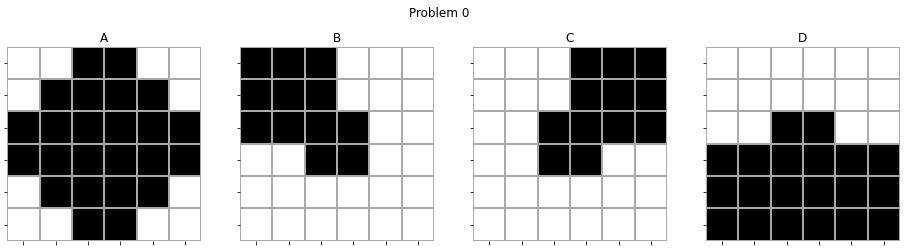

In [12]:
ident_idx = 0
print(identifiable_bool[ident_idx])
_ = teach.plot_problem(ident_idx)

Plot a non-identifiable problem:

False


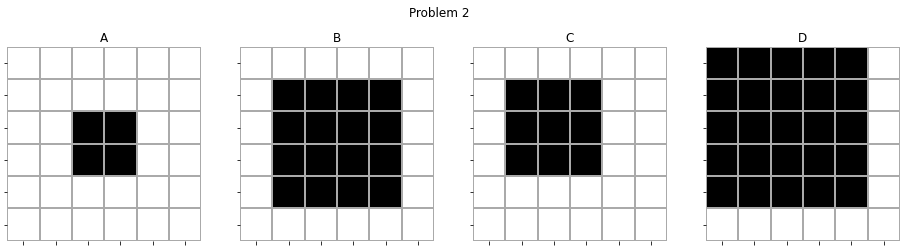

In [13]:
nonident_idx = 2
print(identifiable_bool[nonident_idx])
_ = teach.plot_problem(nonident_idx)

Helper function: Make event files

In [16]:
def make_identifiable_reg(f):
    # get event data
    event_df = data_wrangling(f)

    # split "show" trials based on whether a hint was selected
    choose_trials = event_df[event_df.trial_type == 'choose'].copy()
    choose_trials['stimuli'] = choose_trials['stimuli'].astype(int)
    identifiable = choose_trials.stimuli.apply(lambda p: identifiable_bool[p])
    missed_trial = pd.isnull(choose_trials.response)
    show_renamed = np.where(missed_trial, 'show_missed', 
                            np.where(identifiable, 'show_identifiable', 'show_unidentifiable'))
    event_df.loc[event_df.trial_type == 'show', 'trial_type'] = show_renamed

    # merge with event files
    show_trials = (
        event_df
        [event_df.trial_type.str.contains('identifiable')]
        .copy()
        .drop(columns='trial_type')
    )

    # put everything together
    model_events = (
        pd.concat([event_df, show_trials])
        .sort_values(by=['onset', 'trial_type'])
        [['onset', 'duration', 'stimuli', 'trial_type']]
        .dropna(axis='index', subset=['trial_type'])
        .reset_index(drop=True)
    )

    return model_events

Save to file:

In [17]:
out_dir = '../../BIDS_data/derivatives/model_events'
os.makedirs(out_dir, exist_ok=True)

for f in original_files:
    sub = str_extract('sub-[0-9]{2}', f)
    run = str_extract('run-[0-9]{2}', f)
    out_f = opj(out_dir, sub, 'func', f'{sub}_task-teaching_{run}_model-identifiability_events.tsv')
    
    if sub in valid_participants:
        print(f'\nLoading file: {f}')
        out_df = make_identifiable_reg(f)
        os.makedirs(opj(out_dir, sub, 'func'), exist_ok=True)
        print(f'Saving to: {out_f}')
        out_df.to_csv(out_f, sep='\t', index=False, na_rep='n/a')
#         is_complete = set(['show_identifiable', 'show_unidentifiable']).issubset(set(out_df.trial_type))
        
#         if is_complete:
#             print(f'Saving to: {out_f}\n')
#             os.makedirs(opj(out_dir, sub, 'func'), exist_ok=True)
#             out_df.to_csv(out_f, sep='\t', index=False, na_rep='n/a')
#         else:
#             warnings.warn(f'Skipping {sub}, {run}')


Loading file: ../../behavioral/sub-01_task-teaching_run-01_behavioral_1628798255.json
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-01_model-identifiability_events.tsv

Loading file: ../../behavioral/sub-01_task-teaching_run-02_behavioral_1628798680.json
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-02_model-identifiability_events.tsv

Loading file: ../../behavioral/sub-01_task-teaching_run-03_behavioral_1628799162.json
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-03_model-identifiability_events.tsv

Loading file: ../../behavioral/sub-01_task-teaching_run-04_behavioral_1628800012.json
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-04_model-identifiability_events.tsv

Loading file: ../../behavioral/sub-01_task-teaching_run-05_behavioral_1628800423.json
Saving to: ../../BIDS_data/derivatives/model_events/sub-01/func/s